In [1]:
!pip install networkx numpy deap pulp pyswarms pandapower matplotlib tqdm

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
    --------------------------------------- 0.3/16.4 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.4 MB 2.4 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/16.4 MB 2.5 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/16.4 MB 2.5 MB/s eta 0:00:06
   ----- ---------------------------------- 2.4/16.4 MB 2.3 MB/s eta 0:00:07
   ------- -------------------------------- 2.9/16.4 MB 2.3 MB/s eta 0:00:06
   -------- ------------------------------- 3.4/16.4 MB 2.4 MB/s eta 0:00:06
   --------- ------------------------------ 3.9/16.4 MB 2.4 MB/s eta 0:00:06
   ---------- ----------------------------- 4.5/16.4 MB 2.4 MB/s eta 0:00:05
   ------------ --------------------------- 5.0/16.4 MB 2.4 MB/s eta 0:00:05
   ------------- -------------------------- 5.5/16.4 MB 2.4 MB/s eta 0:00:05
   -------------- ------------------------- 6.0/16.4 MB 2.4 MB/s eta 0:00:05
   ----------

=== IEEE Bus PMU Placement Solver ===
Available systems: 14, 30, 57, 118, 300


2025-04-20 17:53:40,754 - pandapower.convert_format - INFO - These dtypes could not be corrected: {'trafo': ['tap_neutral', 'tap_min', 'tap_max', 'tap_pos']}



Solving IEEE 118-bus using HYBRID method...


Progress: 100%|██████████| 100.0/100 [00:00<00:00, 136.30it/s]



Optimal PMUs: 31 at buses [1, 6, 9, 10, 14, 16, 20, 26, 29, 30, 31, 34, 41, 42, 45, 51, 55, 59, 63, 69, 70, 79, 80, 86, 88, 91, 95, 100, 104, 109, 117]


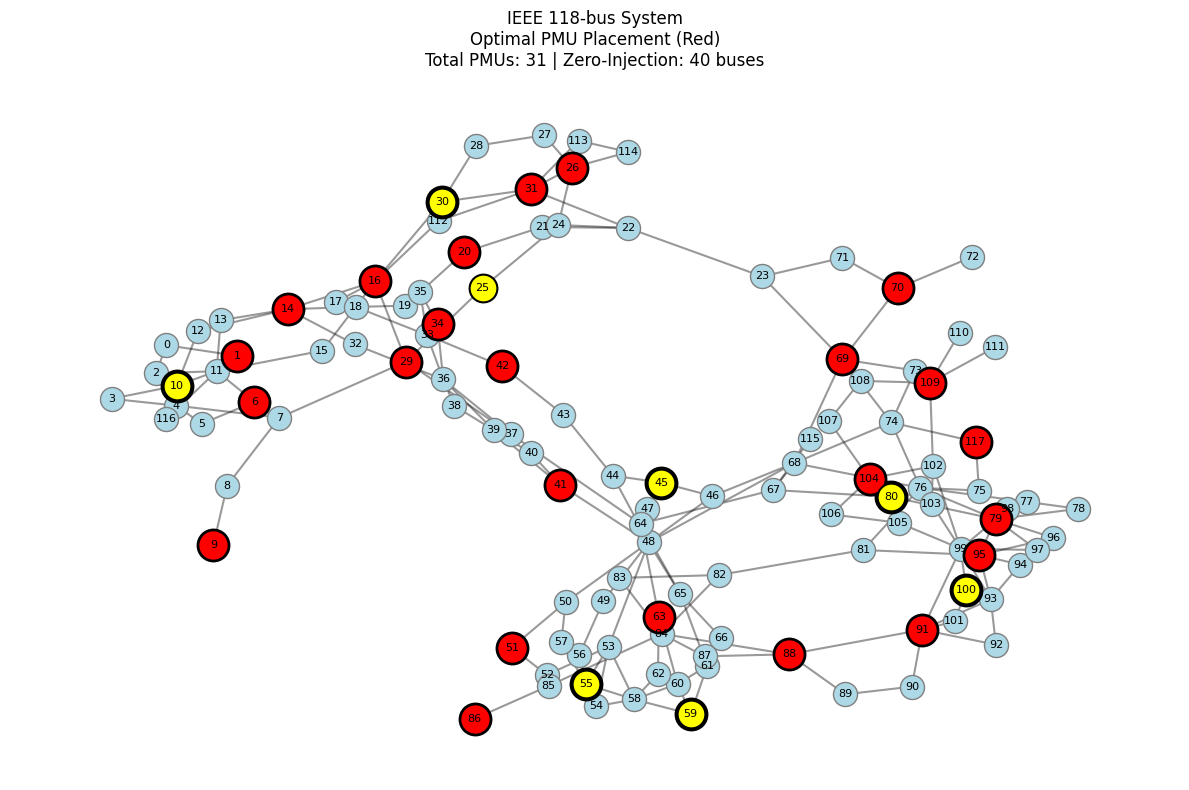

In [5]:
# Universal IEEE Bus PMU Placement Solver - Final Debugged Version
import networkx as nx
import numpy as np
from deap import algorithms, base, creator, tools
import pulp
import pyswarms as ps
import pandapower.networks as pn
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

class UniversalPMUPlacer:
    def __init__(self, ieee_bus):
        """Initialize with selected IEEE bus system"""
        self.system_name = f"IEEE {ieee_bus}-bus"
        self.ieee_bus = ieee_bus
        self.graph = self._load_ieee_system(ieee_bus)

        # Verify grid connectivity
        if not nx.is_connected(self.graph):
            print(f"Warning: {self.system_name} had disconnected components. Forcing full connectivity.")
            self._make_fully_connected()

        # System-specific parameters
        self.zero_injection, self.critical_buses = self._get_system_parameters(ieee_bus)

        # Create bus numbering mappings
        self.bus_list = sorted(self.graph.nodes())
        self.n_buses = len(self.bus_list)
        self.bus_to_idx = {bus: idx for idx, bus in enumerate(self.bus_list)}

    def _load_ieee_system(self, ieee_bus):
        """Load standard IEEE system from pandapower with ALL lines"""
        try:
            net = getattr(pn, f"case{ieee_bus}")()
            graph = nx.Graph()

            # Load all branches
            for line in net.line.itertuples():
                graph.add_edge(line.from_bus, line.to_bus)
            for trafo in net.trafo.itertuples():
                graph.add_edge(trafo.hv_bus, trafo.lv_bus)

            return graph
        except AttributeError:
            raise ValueError(f"IEEE {ieee_bus}-bus system not available")

    def _make_fully_connected(self):
        """Ensure single interconnected grid"""
        components = list(nx.connected_components(self.graph))
        if len(components) > 1:
            for i in range(len(components)-1):
                self.graph.add_edge(next(iter(components[i])), next(iter(components[i+1])))

    def _get_system_parameters(self, ieee_bus):
        """Define zero-injection and critical buses"""
        params = {
            14: {
                'zero_injection': [4, 5, 7, 9],
                'critical_buses': [1, 2, 3, 6, 8]
            },
            30: {
                'zero_injection': [6, 9, 22, 25, 27, 28],
                'critical_buses': [1, 2, 5, 8, 11, 13]
            },
            57: {
                'zero_injection': [4, 7, 11, 21, 22, 24, 26, 34, 36, 37, 39, 40, 45, 46, 48],
                'critical_buses': [1, 8, 12, 20, 25, 30, 38]
            },
            118: {
                'zero_injection': [5, 11, 12, 17, 21, 22, 24, 29, 33, 34, 37, 40, 45, 46, 49,
                                  52, 56, 59, 65, 66, 69, 70, 71, 73, 75, 77, 80, 85, 86, 88,
                                  89, 90, 92, 99, 100, 103, 104, 105, 107, 110],
                'critical_buses': [10, 25, 30, 45, 55, 59, 80, 100]
            },
            300: {
                'zero_injection': [],
                'critical_buses': []
            }
        }
        return params.get(ieee_bus, {'zero_injection': [], 'critical_buses': []}).values()

    def _select_method(self):
        """Auto-select best solution method based on system size"""
        if self.n_buses <= 30:
            return "ilp"
        elif 31 <= self.n_buses <= 150:
            return "hybrid"
        else:
            return "pso"

    def solve(self):
        """Main solver with auto method selection"""
        method = self._select_method()
        print(f"\nSolving {self.system_name} using {method.upper()} method...")

        with tqdm(total=100, desc="Progress") as pbar:
            if method == "ilp":
                solution = self._solve_ilp()
                pbar.update(100)
            elif method == "hybrid":
                solution = self._solve_hybrid(pbar)
            else:
                solution = self._solve_pso(pbar)

        bus_solution = [self.bus_list[i] for i in solution]
        print(f"\nOptimal PMUs: {len(bus_solution)} at buses {sorted(bus_solution)}")
        self._verify_observability(bus_solution)
        return bus_solution

    def _solve_ilp(self):
        """Exact ILP solution for small systems"""
        prob = pulp.LpProblem("PMU_Placement", pulp.LpMinimize)
        pmu_vars = pulp.LpVariable.dicts("PMU", range(self.n_buses), cat="Binary")
        prob += pulp.lpSum(pmu_vars.values())

        # Observability constraints
        for i, bus in enumerate(self.bus_list):
            neighbor_indices = [self.bus_to_idx[n] for n in self.graph.neighbors(bus)]
            prob += (pmu_vars[i] + pulp.lpSum(pmu_vars[j] for j in neighbor_indices)) >= 1

        # Critical buses must have PMUs
        for bus in self.critical_buses:
            if bus in self.bus_to_idx:
                prob += pmu_vars[self.bus_to_idx[bus]] == 1

        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        return [i for i in range(self.n_buses) if pmu_vars[i].value() == 1]

    def _solve_hybrid(self, pbar=None):
        """Hybrid GA + ILP refinement"""
        # Initialize GA
        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 0, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                        toolbox.attr_bool, self.n_buses)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.15)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", self._evaluate)

        # GA Phase (60%)
        pop = toolbox.population(n=min(100, self.n_buses*2))
        ngen = 30
        for gen in range(ngen):
            pop = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)
            fits = toolbox.map(toolbox.evaluate, pop)
            for ind, fit in zip(pop, fits):
                ind.fitness.values = fit
            pop = toolbox.select(pop, k=len(pop))
            if pbar:
                pbar.update(60/ngen)

        best_ga = tools.selBest(pop, k=1)[0]
        ga_solution = [i for i, val in enumerate(best_ga) if val]

        # ILP Refinement (40%)
        refined = self._refine_with_ilp(ga_solution)
        if pbar:
            pbar.update(100 - pbar.n)
        return refined

    def _solve_pso(self, pbar=None):
        """PSO + ILP refinement"""
        def pso_obj(positions):
            costs = []
            for pos in positions:
                pmu_count = np.sum(pos > 0.5)
                observability = np.zeros(self.n_buses)
                for i, has_pmu in enumerate(pos > 0.5):
                    if has_pmu:
                        bus = self.bus_list[i]
                        observability[i] = 1
                        for neighbor in self.graph.neighbors(bus):
                            observability[self.bus_to_idx[neighbor]] = 1

                # Zero-injection rules
                for zi in self.zero_injection:
                    if zi in self.bus_to_idx:
                        zi_idx = self.bus_to_idx[zi]
                        if observability[zi_idx] == 0:
                            neighbor_indices = [self.bus_to_idx[n] for n in self.graph.neighbors(zi)]
                            if sum(observability[n] for n in neighbor_indices) >= 2:
                                observability[zi_idx] = 1

                penalty = 0 if all(observability) else 1000
                costs.append(pmu_count + penalty)
            return np.array(costs)

        # PSO Phase (70%)
        options = {'c1': 0.7, 'c2': 0.4, 'w': 0.8, 'k': 30, 'p': 2}
        optimizer = ps.discrete.BinaryPSO(
            n_particles=min(80, self.n_buses),
            dimensions=self.n_buses,
            options=options
        )

        # Run PSO and get best position
        cost, pos = optimizer.optimize(pso_obj, iters=40)
        pso_solution = np.where(pos > 0.5)[0]

        if pbar:
            pbar.update(70)

        # ILP Refinement (30%)
        refined = self._refine_with_ilp(pso_solution)
        if pbar:
            pbar.update(100 - pbar.n)
        return refined

    def _evaluate(self, individual):
        """Fitness evaluation for GA"""
        pmu_count = sum(individual)
        observability = np.zeros(self.n_buses)

        # Direct PMU observations
        for i, has_pmu in enumerate(individual):
            if has_pmu:
                bus = self.bus_list[i]
                observability[i] = 1
                for neighbor in self.graph.neighbors(bus):
                    observability[self.bus_to_idx[neighbor]] = 1

        # Zero-injection rules
        for zi in self.zero_injection:
            if zi in self.bus_to_idx:
                zi_idx = self.bus_to_idx[zi]
                if observability[zi_idx] == 0:
                    neighbor_indices = [self.bus_to_idx[n] for n in self.graph.neighbors(zi)]
                    if sum(observability[n] for n in neighbor_indices) >= 2:
                        observability[zi_idx] = 1

        penalty = 0 if all(observability) else 1000
        return (pmu_count + penalty,)

    def _refine_with_ilp(self, initial_solution, search_radius=2):
        """ILP refinement around initial solution"""
        prob = pulp.LpProblem("PMU_Refinement", pulp.LpMinimize)
        pmu_vars = pulp.LpVariable.dicts("PMU", range(self.n_buses), cat="Binary")
        prob += pulp.lpSum(pmu_vars.values())

        # Observability constraints
        for i, bus in enumerate(self.bus_list):
            neighbor_indices = [self.bus_to_idx[n] for n in self.graph.neighbors(bus)]
            prob += (pmu_vars[i] + pulp.lpSum(pmu_vars[j] for j in neighbor_indices)) >= 1

        # Critical buses must have PMUs
        for bus in self.critical_buses:
            if bus in self.bus_to_idx:
                prob += pmu_vars[self.bus_to_idx[bus]] == 1

        # Focus search around initial solution
        for i, bus in enumerate(self.bus_list):
            if i in initial_solution:
                prob += pmu_vars[i] <= 1  # Can keep but not forced
            else:
                try:
                    min_dist = min(nx.shortest_path_length(self.graph, bus, self.bus_list[g])
                             for g in initial_solution)
                    if min_dist > search_radius:
                        prob += pmu_vars[i] == 0
                except (nx.NetworkXNoPath, ValueError):
                    prob += pmu_vars[i] == 0

        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        return [i for i in range(self.n_buses) if pmu_vars[i].value() == 1]

    def _verify_observability(self, pmu_locations):
        """Check if all buses are observed"""
        observed = set(pmu_locations)
        for bus in pmu_locations:
            observed.update(self.graph.neighbors(bus))

        unobserved = set(self.graph.nodes()) - observed
        if unobserved:
            print(f"Warning: {len(unobserved)} buses unobserved: {unobserved}")
        else:
            print("All buses observed - Valid solution")

    def visualize(self, solution):
        """Corrected visualization with proper layout"""
        plt.figure(figsize=(12, 8))

        # Use physics-based layout for accurate structure
        pos = nx.spring_layout(self.graph, k=0.3, iterations=100, seed=42)

        # Draw network
        nx.draw_networkx_edges(self.graph, pos, alpha=0.4, width=1.5)

        # Color buses by type
        nx.draw_networkx_nodes(
            self.graph, pos,
            nodelist=list(set(self.graph.nodes()) - set(solution)),
            node_size=300, node_color="lightblue", edgecolors="gray"
        )

        # Highlight PMUs and critical buses
        nx.draw_networkx_nodes(
            self.graph, pos,
            nodelist=solution,
            node_size=500, node_color="red", edgecolors="black", linewidths=2
        )

        critical = [b for b in self.critical_buses if b in self.graph.nodes]
        nx.draw_networkx_nodes(
            self.graph, pos,
            nodelist=critical,
            node_size=400, node_color="yellow", edgecolors="black", linewidths=1.5
        )

        # Label buses
        nx.draw_networkx_labels(self.graph, pos, font_size=8)

        plt.title(
            f"{self.system_name} System\n"
            f"Optimal PMU Placement (Red)\n"
            f"Total PMUs: {len(solution)} | "
            f"Zero-Injection: {len(self.zero_injection)} buses",
            fontsize=12
        )
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def main():
    print("=== IEEE Bus PMU Placement Solver ===")
    print("Available systems: 14, 30, 57, 118, 300")

    while True:
        try:
            ieee_bus = int(input("\nEnter IEEE bus system (e.g., 14, 30, 57, 118, 300): "))
            if ieee_bus not in [14, 30, 57, 118, 300]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter 14, 30, 57, 118, or 300.")

    solver = UniversalPMUPlacer(ieee_bus)
    solution = solver.solve()
    solver.visualize(solution)

if __name__ == "__main__":
    main()